# Part 1 - EDA

In [3]:
#load libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelextrema
import seaborn as sns
import plotly.express as px
from datetime import datetime

In [4]:
#load data
df = pd.read_json('../logins.json')

In [5]:
df['col2'] = [i for i in range(93142)]

In [6]:
df_15min = pd.DataFrame(df.groupby(pd.Grouper(key='login_time', freq='15Min')).col2.sum()).reset_index()

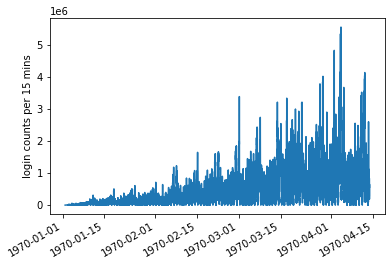

In [7]:
#login counts aggregated by 15 mins
plt.plot(df_15min['login_time'], df_15min['col2'])
plt.gcf().autofmt_xdate()
plt.ylabel('login counts per 15 mins')
plt.show()

In [8]:
df_1day = pd.DataFrame(df.groupby(pd.Grouper(key='login_time', freq='24H')).col2.sum()).reset_index()

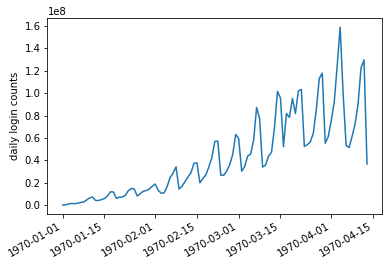

In [9]:
#login counts aggregated daily
plt.plot(df_1day['login_time'], df_1day['col2'])
plt.gcf().autofmt_xdate()
plt.ylabel('daily login counts')
plt.show()

The number of login aggregated daily has an uptrend with an increasing variance from Jan 1970 to the beginning of April 1970, and starts to decrease from the beginning of April 1970 to the mid of April 1970. The data show a clear cycle which require further investigation. We now investigate the local peaks of each cycle.

In [10]:
#local max
temp = np.array(df.groupby(pd.Grouper(key='login_time', freq='24H')).col2.sum())
y = argrelextrema(temp, np.greater)
local_max = df.groupby(pd.Grouper(key='login_time', freq='24H')).col2.sum().index[y]
local_max

DatetimeIndex(['1970-01-04', '1970-01-11', '1970-01-17', '1970-01-24',
               '1970-02-01', '1970-02-08', '1970-02-15', '1970-02-22',
               '1970-02-28', '1970-03-07', '1970-03-14', '1970-03-17',
               '1970-03-19', '1970-03-22', '1970-03-29', '1970-04-04',
               '1970-04-12'],
              dtype='datetime64[ns]', name='login_time', freq=None)

In [11]:
#local min
y = argrelextrema(temp, np.less)
local_min = df.groupby(pd.Grouper(key='login_time', freq='24H')).col2.sum().index[y]
local_min

DatetimeIndex(['1970-01-05', '1970-01-13', '1970-01-19', '1970-01-26',
               '1970-02-03', '1970-02-09', '1970-02-16', '1970-02-24',
               '1970-03-02', '1970-03-09', '1970-03-16', '1970-03-18',
               '1970-03-20', '1970-03-23', '1970-03-30', '1970-04-07'],
              dtype='datetime64[ns]', name='login_time', freq=None)

The peaks are obtained every 6-7 days, which are Sundays and Saturdays accordingly. This indicates that people login more during the weekend. The local minimum are obtained on Mondays.

# Part 2 - Experiment and metrics design

#### Question 1: What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

The ultimate goal is to encourage driver partners to be available in both cities. Assume that we would like to test if toll costs reimbursement helps us achieve this goal, we would like to find a metric that measures the "availability of driver partners in both cities". 


A metric we can use is the number of rides in both cities and between the cities in a given time frame. This metric directly relates to the "availability of driver partners". By comparing the number of rides before and after applying the reimbursement, we can see if the new proposal helps with increasing the number of rides in the area.

#### Question 2: Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success

We will implement the experiment as follows. We apply the policy in a time frame and collect the data. If we see an increase in the number of rides in the area, we run a stastical test to verify the significance of the observation.
We will choose one side T-test for this experiment since we care if the new mean of number of ride in a time frame is indeed bigger than the old mean before we apply the reimbursement. In particular, our $H_0$ hypothesis would be $\mu_0 = \mu_1$ and $H_1$ is $\mu_1 > \mu_0$, where $\mu_0$ is the mean before the reimbursement and $\mu_1$ is the mean after the reimbursement.
We need to set up the significance level $\alpha$ and $p-value$ before the testing. If the test yields the p-value < 0.05, we rejects the null hypothesis, meaning the policy is worth applying. However, we need to be careful about any bias that can appear when we collect data, and carefully look at these bias when we intepret the result.  

# Part 3 - Predictive modeling

The goal of this part is to understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights.

### Data cleaning and EDA

In [12]:
df = pd.read_json('../ultimate_data_challenge.json')

In [13]:
df.shape

(50000, 12)

In [14]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Among the columns, only 'avg_rating_of_driver' has many missing values (about 20% are missing), which might require extra care when dealing with. We now create a column name 'retained' to indicate which driver has retained. Recall that we consider a user retained if they are active in the preceding 30 days.

In [16]:
df['last_trip_date'].value_counts().sort_values()

2014-03-04      69
2014-03-10      69
2014-02-20      74
2014-02-26      79
2014-03-11      79
              ... 
2014-06-22    1024
2014-06-27    1120
2014-06-30    1408
2014-06-28    1679
2014-06-29    2036
Name: last_trip_date, Length: 182, dtype: int64

The latest date recorded is 2014-06-29. We label drivers who has the last trip from 2014-05-29 to 2014-06-29 as 1 (retained) and 0 otherwise

In [17]:
df['retained'] = np.where(df['last_trip_date'] < '2014-05-29', 1, 0)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,1
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,1
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,0
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,1


In [18]:
#correlation table
corr = df.apply(lambda x : pd.factorize(x)[0]).corr(method = 'pearson')
corr.iloc[:,-1:]

,retained
city,0.160991
trips_in_first_30_days,-0.086554
signup_date,0.009069
avg_rating_of_driver,-0.173984
avg_surge,-0.196964
last_trip_date,0.378316
phone,0.209814
surge_pct,-0.285387
ultimate_black_user,0.196101
weekday_pct,-0.340546


The factors that have biggest correlation with 'retained' are 'last_trip_date' (as expected), 'weekday_pct', 'surge_pct', 'avg_rating_by_driver', 'phone', 'ultimate_black_user', and 'avg_surge'. On the other hand, 'signup_date' has the smallest correlation with 'retained'.

In [19]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retained
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000,50000.00000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158,0.60512
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652,0.48883
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000,0.00000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000,1.00000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000,1.00000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000,1.00000


The columns 'trips_in_first_30_days', 'avg_surge', 'surge_pct', 'avg_dist' have max value very far from their means, which indicate possible outliers. Among these, 'trips_in_first_30_days' and 'avg_dist' have no strong relationship with 'retained', so we further investigate 'avg_surge' and 'surge_pct' columns.

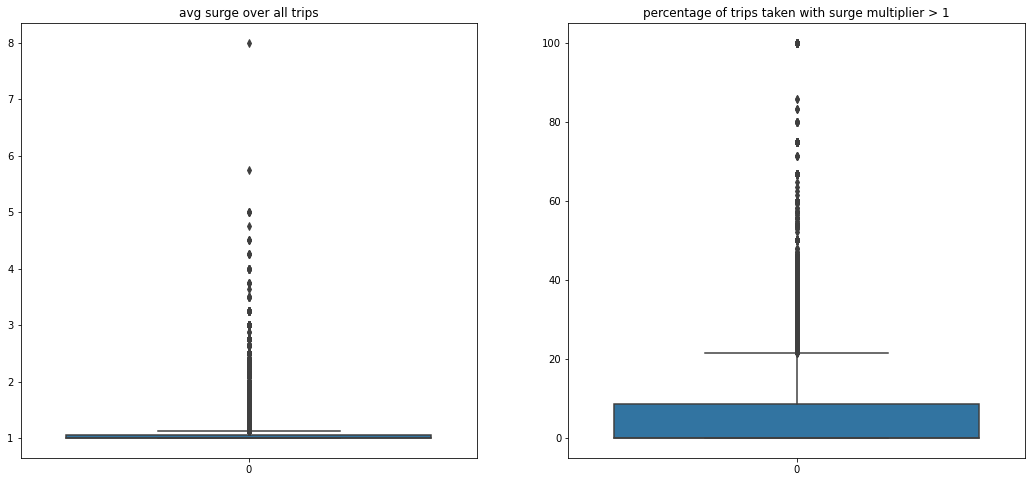

In [20]:
fig, ax = plt.subplots(1,2, figsize = (18,8))

sns.boxplot(ax = ax[0], data = df['avg_surge'])
ax[0].set_title('avg surge over all trips')
sns.boxplot(ax = ax[1], data = df['surge_pct'])
ax[1].set_title('percentage of trips taken with surge multiplier > 1')
plt.show()

In [21]:
#outlier for 'avg_surge'
df[(df['avg_surge'] > 7)]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
13861,Winterfell,1,2014-01-01,1.0,8.0,2014-01-01,iPhone,100.0,False,100.0,5.77,5.0,1


In [22]:
#outlier for 'surge_pct'
df[(df['surge_pct'] > 90)]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
28,Winterfell,0,2014-01-19,NaN,1.50,2014-06-08,iPhone,100.0,False,0.0,5.97,5.0,0
32,Winterfell,1,2014-01-05,4.0,2.00,2014-06-10,iPhone,100.0,False,100.0,10.01,5.0,0
34,Astapor,1,2014-01-16,NaN,1.25,2014-01-17,Android,100.0,False,100.0,4.12,5.0,1
42,Winterfell,1,2014-01-25,4.0,1.50,2014-01-26,Android,100.0,False,0.0,5.72,5.0,1
47,Winterfell,1,2014-01-18,5.0,1.25,2014-01-19,iPhone,100.0,False,0.0,3.61,5.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49891,Astapor,0,2014-01-06,NaN,1.50,2014-03-30,iPhone,100.0,False,0.0,1.07,3.0,1
49894,Winterfell,0,2014-01-11,5.0,1.25,2014-02-21,iPhone,100.0,False,100.0,5.18,5.0,1
49928,Astapor,1,2014-01-04,5.0,2.00,2014-01-11,iPhone,100.0,False,100.0,0.58,5.0,1
49974,Winterfell,1,2014-01-05,5.0,2.00,2014-01-18,iPhone,100.0,False,100.0,4.63,5.0,1


We can safely remove the outlier with avg_surge > 7.

In [23]:
df = df[df['avg_surge'] <= 7]

In [91]:
print('percentage of users who have retained is' , df['retained'].sum()/df.shape[0]*100, '%')

percentage of users who have retained is 60.51121022420448 %


### Data preprocessing

In [24]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [46]:
temp = df
temp = temp.drop(columns = ['last_trip_date', 'signup_date'])
temp = temp.dropna()

In [47]:
temp = pd.get_dummies(temp)

In [58]:
#split train, test set
y = temp['retained']
X = temp.drop(columns = ['retained'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

### Modeling

##### Logistic regression

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
confusion_matrix(y_pred, y_test)

/Users/quinn/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([[2977, 1374],
       [2418, 5665]])

##### Random forest

In [62]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
confusion_matrix(y_pred, y_test)

array([[3803, 1594],
       [1592, 5445]])

##### Gradient boosting

In [65]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(max_depth = 3)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
confusion_matrix(y_pred, y_test)

array([[3802, 1202],
       [1593, 5837]])

Assume that we want to identify users who are not likely to retain early (to have on-time action to keep them), we would like to minimize false positive as possible. Gradient boosting yields the best results in terms of false positive rate.

##### Assessing performance using cross-validation

In [71]:
from sklearn.model_selection import RepeatedStratifiedKFold

In [75]:
gb = GradientBoostingClassifier()
rf = RandomForestClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores_gb = cross_val_score(gb, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
n_scores_rf = cross_val_score(rf, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy of gradient boosting: %.3f' % (np.mean(n_scores_gb)))
print('Accuracy of random forest: %.3f' % (np.mean(n_scores_rf)))

Accuracy of gradient boosting: 0.775
Accuracy of random forest: 0.744


### Results

In [87]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
feature_importance = pd.DataFrame(X_train.columns) 
feature_importance['weight'] = gb.feature_importances_
feature_importance.sort_values(by = 'weight', ascending = False)

,0,weight
7,avg_rating_by_driver,0.261305
3,surge_pct,0.163632
5,weekday_pct,0.159207
9,city_King's Landing,0.155679
4,ultimate_black_user,0.071510
12,phone_iPhone,0.044945
0,trips_in_first_30_days,0.037142
11,phone_Android,0.033045
6,avg_dist,0.023290
1,avg_rating_of_driver,0.022171


The features that are the most important in the model are 'avg_rating_by_driver', 'surge_pct', and 'weekday_pct'. The model is good in detecting if someone is likely to retain or not. However, it can not tell the reason why someone might not retain. To improve the retention rate, Ultimate should have on-time action when the model classifies someone as 'not retained in 6 months' by providing support or sending emails to figure out the problems. 